### Prerequisites

- Generated he labeles from the k-means generator script

In [2]:
import numpy as np
import matplotlib.cm as cm
from matplotlib import ticker
import math
import scipy
from scipy import spatial
import matplotlib.pyplot as plt
import matplotlib
#import mpl_scatter_density
import xarray as xr
import dask
from sklearn.neighbors import KDTree
import netCDF4
from metpy import calc
from metpy.units import units

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
from IPython.display import HTML
from matplotlib import animation
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde
import skimage
import plotly.graph_objects as go

from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from statistics import mode
from matplotlib import transforms
import netCDF4

In [3]:
path = "/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-20-00000.nc"
extra_variables = xr.open_dataset(path)
ha = extra_variables.hyai.values
hb = extra_variables.hybi.values
PS = 1e5
Pressures_real = PS*ha+PS*hb

In [4]:
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

In [5]:
others = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc")
levs = np.array(others.variables['lev'])
lons = np.array(others.variables['lon'])
new = np.flip(levs)
crms = np.arange(1,129,1)
Xs, Zs = np.meshgrid(crms, new)

In [6]:
path_to_file = '/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc'
extra_variables = xr.open_dataset(path_to_file)
latitudes = np.squeeze(extra_variables.LAT_20s_to_20n.values)
longitudes = np.squeeze(extra_variables.LON_0e_to_360e.values)
new_lons, new_lats = np.meshgrid(longitudes, latitudes)

In [7]:
lat_keys = np.arange(0,22,1)
lat_values = latitudes
lon_keys = np.arange(0,144,1)
lon_values = longitudes

In [8]:
lat_dic = dict(zip(lat_values, lat_keys))
lon_dic = dict(zip(lon_values, lon_keys))

In [9]:
W_Test_Unscaled = np.load("/fast/gmooers/Preprocessed_Data/Randomized_Third_Day/Unscaled_Randomized_Space_Time_W_Test.npy")
lat_test = np.load('/fast/gmooers/Preprocessed_Data/Randomized_Third_Day/Randomized_Space_Time_Lat_Test.npy')
lon_test = np.load('/fast/gmooers/Preprocessed_Data/Randomized_Third_Day/Randomized_Space_Time_Lon_Test.npy')

## Change paths to labels generated from your multichannel + Single channel VAE

In [10]:
labels_3_multi = np.load("Compressed_Data/Big_Scaled_Reinitialized_0K_Climate_Labels_3100_Z_3.npy")
labels_3_single = np.load("Compressed_Data/SingleVAE_Big_Scaled_Reinitialized_0K_Climate_Labels_3100_Z_3.npy")

In [11]:
ww_test = np.empty(W_Test_Unscaled.shape)
for i in range(len(W_Test_Unscaled)):
    ww_test[i,:,:] = ((W_Test_Unscaled[i,:,:] - np.nanmean(np.squeeze(W_Test_Unscaled[i,:,:]),axis=1)[:,None])**2)**0.5

## Assumption: Three is optimal number of clusters (adjust code if not true) 

In [12]:
MultiVAE_ww_test_1 = ww_test[labels_3_multi ==0,:,:]
MultiVAE_ww_test_2 = ww_test[labels_3_multi ==1,:,:]
MultiVAE_ww_test_3 = ww_test[labels_3_multi ==2,:,:]

SingleVAE_ww_test_1 = ww_test[labels_3_single ==0,:,:]
SingleVAE_ww_test_2 = ww_test[labels_3_single ==1,:,:]
SingleVAE_ww_test_3 = ww_test[labels_3_single ==2,:,:]

In [13]:
MultiVAE_ww_profiles_1 = np.empty(shape=(len(MultiVAE_ww_test_1)*len(MultiVAE_ww_test_1[0][0]), len(MultiVAE_ww_test_1[0])))
MultiVAE_ww_profiles_2 = np.empty(shape=(len(MultiVAE_ww_test_2)*len(MultiVAE_ww_test_2[0][0]), len(MultiVAE_ww_test_2[0])))
MultiVAE_ww_profiles_3 = np.empty(shape=(len(MultiVAE_ww_test_3)*len(MultiVAE_ww_test_3[0][0]), len(MultiVAE_ww_test_3[0])))
for i in range(len(MultiVAE_ww_test_1[0])):
    MultiVAE_ww_profiles_1[:,i] = MultiVAE_ww_test_1[:,i,:].flatten()
    MultiVAE_ww_profiles_2[:,i] = MultiVAE_ww_test_2[:,i,:].flatten()
    MultiVAE_ww_profiles_3[:,i] = MultiVAE_ww_test_3[:,i,:].flatten()

In [14]:
SingleVAE_ww_profiles_1 = np.empty(shape=(len(SingleVAE_ww_test_1)*len(SingleVAE_ww_test_1[0][0]), len(SingleVAE_ww_test_1[0])))
SingleVAE_ww_profiles_2 = np.empty(shape=(len(SingleVAE_ww_test_2)*len(SingleVAE_ww_test_2[0][0]), len(SingleVAE_ww_test_2[0])))
SingleVAE_ww_profiles_3 = np.empty(shape=(len(SingleVAE_ww_test_3)*len(SingleVAE_ww_test_3[0][0]), len(SingleVAE_ww_test_3[0])))
for i in range(len(SingleVAE_ww_test_1[0])):
    SingleVAE_ww_profiles_1[:,i] = SingleVAE_ww_test_1[:,i,:].flatten()
    SingleVAE_ww_profiles_2[:,i] = SingleVAE_ww_test_2[:,i,:].flatten()
    SingleVAE_ww_profiles_3[:,i] = SingleVAE_ww_test_3[:,i,:].flatten()

In [15]:
MultiVAE_ww_mean_profile_1 = np.median(MultiVAE_ww_profiles_1, axis = 0)
MultiVAE_ww_25th_profile_1 = np.percentile(MultiVAE_ww_profiles_1, 25, axis = 0)
MultiVAE_ww_75th_profile_1 = np.percentile(MultiVAE_ww_profiles_1, 75, axis = 0)

MultiVAE_ww_mean_profile_2 = np.median(MultiVAE_ww_profiles_2, axis = 0)
MultiVAE_ww_25th_profile_2 = np.percentile(MultiVAE_ww_profiles_2, 25, axis = 0)
MultiVAE_ww_75th_profile_2 = np.percentile(MultiVAE_ww_profiles_2, 75, axis = 0)

MultiVAE_ww_mean_profile_3 = np.median(MultiVAE_ww_profiles_3, axis = 0)
MultiVAE_ww_25th_profile_3 = np.percentile(MultiVAE_ww_profiles_3, 25, axis = 0)
MultiVAE_ww_75th_profile_3 = np.percentile(MultiVAE_ww_profiles_3, 75, axis = 0)

In [16]:
SingleVAE_ww_mean_profile_1 = np.median(SingleVAE_ww_profiles_1, axis = 0)
SingleVAE_ww_25th_profile_1 = np.percentile(SingleVAE_ww_profiles_1, 25, axis = 0)
SingleVAE_ww_75th_profile_1 = np.percentile(SingleVAE_ww_profiles_1, 75, axis = 0)

SingleVAE_ww_mean_profile_2 = np.median(SingleVAE_ww_profiles_2, axis = 0)
SingleVAE_ww_25th_profile_2 = np.percentile(SingleVAE_ww_profiles_2, 25, axis = 0)
SingleVAE_ww_75th_profile_2 = np.percentile(SingleVAE_ww_profiles_2, 75, axis = 0)

SingleVAE_ww_mean_profile_3 = np.median(SingleVAE_ww_profiles_3, axis = 0)
SingleVAE_ww_25th_profile_3 = np.percentile(SingleVAE_ww_profiles_3, 25, axis = 0)
SingleVAE_ww_75th_profile_3 = np.percentile(SingleVAE_ww_profiles_3, 75, axis = 0)

In [17]:
MultiVAE_lat_lon_map_counter_1 = np.zeros(shape=(22,144))
MultiVAE_lat_lon_map_counter_2 = np.zeros(shape=(22,144))
MultiVAE_lat_lon_map_counter_3 = np.zeros(shape=(22,144))

SingleVAE_lat_lon_map_counter_1 = np.zeros(shape=(22,144))
SingleVAE_lat_lon_map_counter_2 = np.zeros(shape=(22,144))
SingleVAE_lat_lon_map_counter_3 = np.zeros(shape=(22,144))

In [18]:
for i in range(len(labels_3_multi)):
    if labels_3_multi[i] == 0:
        MultiVAE_lat_lon_map_counter_1[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] = MultiVAE_lat_lon_map_counter_1[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] + 1
    if labels_3_multi[i] == 1:
        MultiVAE_lat_lon_map_counter_2[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] = MultiVAE_lat_lon_map_counter_2[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] + 1
    if labels_3_multi[i] == 2:
        MultiVAE_lat_lon_map_counter_3[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] = MultiVAE_lat_lon_map_counter_3[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] + 1

In [19]:
for i in range(len(labels_3_single)):
    if labels_3_single[i] == 0:
        SingleVAE_lat_lon_map_counter_1[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] = SingleVAE_lat_lon_map_counter_1[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] + 1
    if labels_3_single[i] == 1:
        SingleVAE_lat_lon_map_counter_2[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] = SingleVAE_lat_lon_map_counter_2[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] + 1
    if labels_3_single[i] == 2:
        SingleVAE_lat_lon_map_counter_3[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] = SingleVAE_lat_lon_map_counter_3[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] + 1

In [20]:
vmax = max([np.max(SingleVAE_lat_lon_map_counter_1),np.max(SingleVAE_lat_lon_map_counter_2),np.max(SingleVAE_lat_lon_map_counter_3),np.max(MultiVAE_lat_lon_map_counter_1),np.max(MultiVAE_lat_lon_map_counter_2),np.max(MultiVAE_lat_lon_map_counter_3)])

No handles with labels found to put in legend.


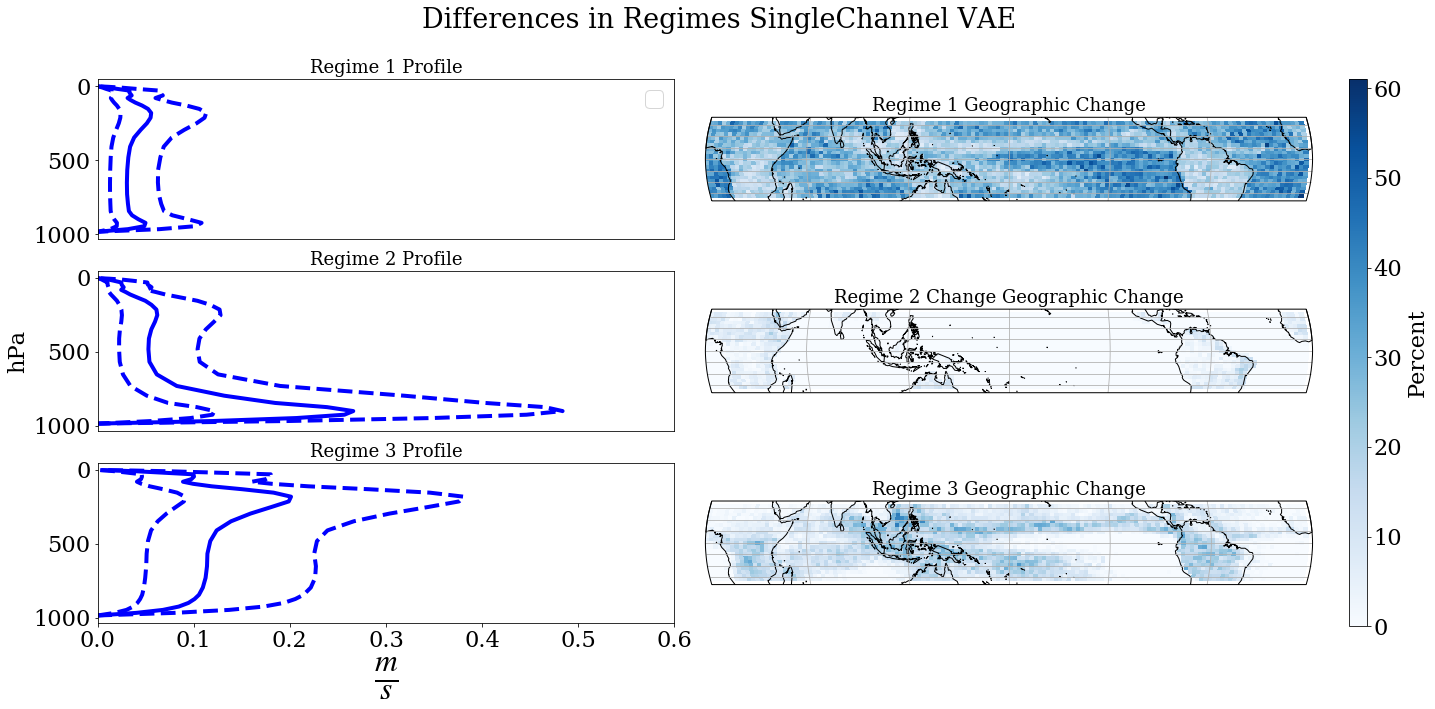

In [21]:
fig, ax = plt.subplots(3,2,figsize=(25,10),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
gs=GridSpec(3,2, width_ratios=[1.9, 2.1])

ax1=fig.add_subplot(gs[0,0])
ax1.plot(np.flipud(SingleVAE_ww_mean_profile_1), Pressures_real[:-1]/100.0, c="blue")
ax1.plot(np.flipud(SingleVAE_ww_25th_profile_1), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
ax1.plot(np.flipud(SingleVAE_ww_75th_profile_1), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
ax1.set_xlim(0,0.6)
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_xticks([])
ax1.set_title("Regime 1 Profile", fontsize = 0.8*fz)
ax1.legend()

ax2=fig.add_subplot(gs[1,0])
ax2.plot(np.flipud(SingleVAE_ww_mean_profile_2), Pressures_real[:-1]/100.0, c="blue")
ax2.plot(np.flipud(SingleVAE_ww_25th_profile_2), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
ax2.plot(np.flipud(SingleVAE_ww_75th_profile_2), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
ax2.set_xlim(0,1.0)
ax2.set_ylabel("hPa")
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_xticks([])
ax2.set_title("Regime 2 Profile", fontsize = 0.8*fz)

ax3=fig.add_subplot(gs[2,0])
ax3.plot(np.flipud(SingleVAE_ww_mean_profile_3), Pressures_real[:-1]/100.0, c="blue")
ax3.plot(np.flipud(SingleVAE_ww_25th_profile_3), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
ax3.plot(np.flipud(SingleVAE_ww_75th_profile_3), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
ax3.set_xlim(0,0.6)
ax3.set_ylim(ax3.get_ylim()[::-1])
ax3.set_xlabel(r"$\frac{m}{s}$", fontsize=fz*2.0)
ax3.set_title("Regime 3 Profile", fontsize = 0.8*fz)

contour_plot = ax[0,1].pcolormesh(new_lons, new_lats, SingleVAE_lat_lon_map_counter_1, cmap="Blues", transform=ccrs.PlateCarree(), vmin=0, vmax = vmax)
# ax[0,1].coastlines(linewidth=0.5,edgecolor='0.25') 
ax[0,1].gridlines()
# ax[0,1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax[0,1].add_feature(cfeature.GSHHSFeature(edgecolor='k'))
ax[0,1].set_title("Regime 1 Geographic Change", fontsize = 0.8*fz)

contour_plot = ax[1,1].pcolormesh(new_lons, new_lats, SingleVAE_lat_lon_map_counter_2, cmap="Blues", transform=ccrs.PlateCarree(), vmin=0, vmax = vmax)
# ax[1,1].coastlines(linewidth=0.5,edgecolor='0.25')
ax[1,1].gridlines()
# ax[1,1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax[1,1].add_feature(cfeature.GSHHSFeature(edgecolor='k'))
ax[1,1].set_title("Regime 2 Change Geographic Change", fontsize = 0.8*fz)

contour_plot = ax[2,1].pcolormesh(new_lons, new_lats, SingleVAE_lat_lon_map_counter_3, cmap="Blues", transform=ccrs.PlateCarree(), vmin=0, vmax = vmax)
# ax[2,1].coastlines(linewidth=0.5,edgecolor='0.25')
ax[2,1].gridlines()
# ax[2,1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax[2,1].add_feature(cfeature.GSHHSFeature(edgecolor='k'))
ax[2,1].set_title("Regime 3 Geographic Change", fontsize = 0.8*fz)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.01, 0.76])
fig.colorbar(contour_plot, label="Percent", cax=cbar_ax)
plt.suptitle("Differences in Regimes SingleChannel VAE", y = 0.98, x=0.47)
plt.subplots_adjust(wspace=0.001)

fig.delaxes(ax[0,0])
fig.delaxes(ax[1,0])
fig.delaxes(ax[2,0])

plt.savefig("Figures/singlechannelVAEregimes.png")
#plt.savefig("Figures/Figure_2.pdf")

No handles with labels found to put in legend.


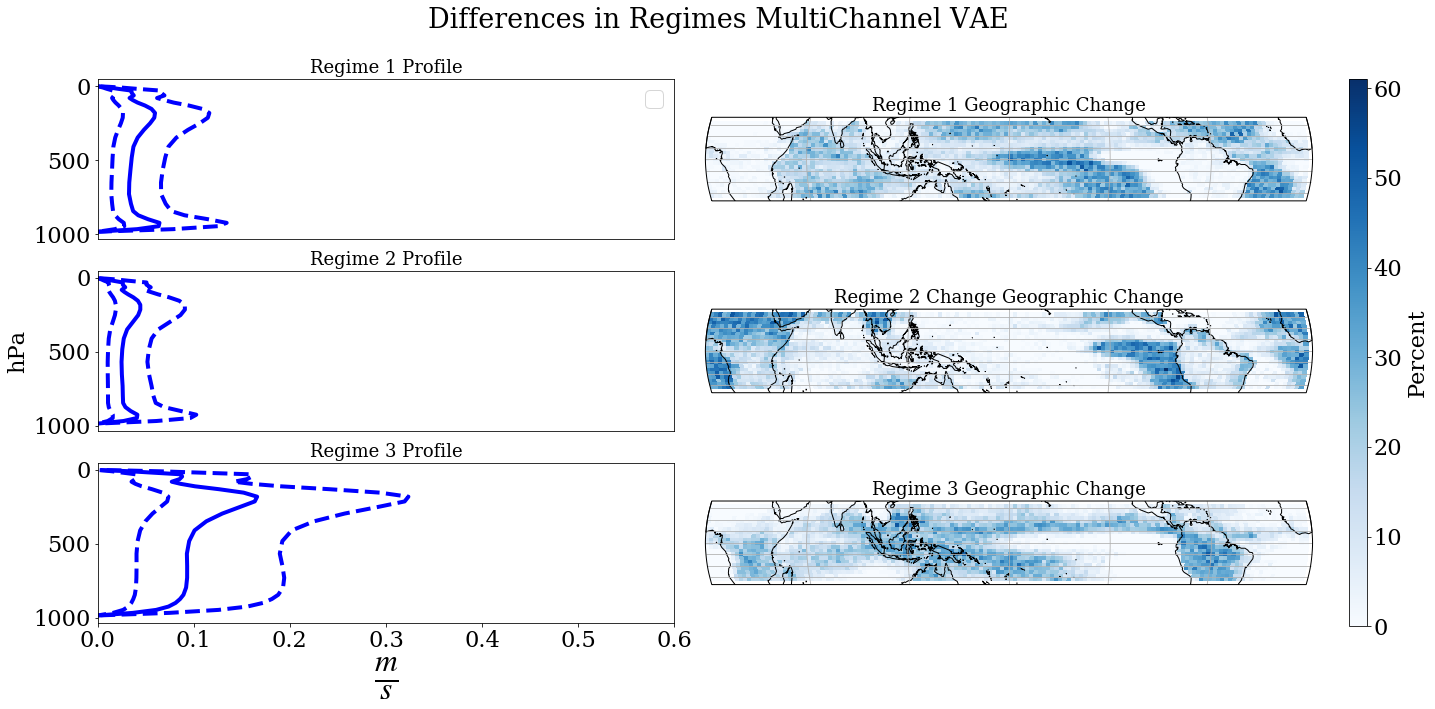

In [22]:
fig, ax = plt.subplots(3,2,figsize=(25,10),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
gs=GridSpec(3,2, width_ratios=[1.9, 2.1])

ax1=fig.add_subplot(gs[0,0])
ax1.plot(np.flipud(MultiVAE_ww_mean_profile_1), Pressures_real[:-1]/100.0, c="blue")
ax1.plot(np.flipud(MultiVAE_ww_25th_profile_1), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
ax1.plot(np.flipud(MultiVAE_ww_75th_profile_1), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
ax1.set_xlim(0,0.6)
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_xticks([])
ax1.set_title("Regime 1 Profile", fontsize = 0.8*fz)
ax1.legend()

ax2=fig.add_subplot(gs[1,0])
ax2.plot(np.flipud(MultiVAE_ww_mean_profile_2), Pressures_real[:-1]/100.0, c="blue")
ax2.plot(np.flipud(MultiVAE_ww_25th_profile_2), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
ax2.plot(np.flipud(MultiVAE_ww_75th_profile_2), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
ax2.set_xlim(0,0.6)
ax2.set_ylabel("hPa")
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_xticks([])
ax2.set_title("Regime 2 Profile", fontsize = 0.8*fz)

ax3=fig.add_subplot(gs[2,0])
ax3.plot(np.flipud(MultiVAE_ww_mean_profile_3), Pressures_real[:-1]/100.0, c="blue")
ax3.plot(np.flipud(MultiVAE_ww_25th_profile_3), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
ax3.plot(np.flipud(MultiVAE_ww_75th_profile_3), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
ax3.set_xlim(0,0.6)
ax3.set_ylim(ax3.get_ylim()[::-1])
ax3.set_xlabel(r"$\frac{m}{s}$", fontsize=fz*2.0)
ax3.set_title("Regime 3 Profile", fontsize = 0.8*fz)

contour_plot = ax[0,1].pcolormesh(new_lons, new_lats, MultiVAE_lat_lon_map_counter_1, cmap="Blues", transform=ccrs.PlateCarree(), vmin=0, vmax = vmax)
# ax[0,1].coastlines(linewidth=0.5,edgecolor='0.25') 
ax[0,1].gridlines()
# ax[0,1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax[0,1].add_feature(cfeature.GSHHSFeature(edgecolor='k'))
ax[0,1].set_title("Regime 1 Geographic Change", fontsize = 0.8*fz)

contour_plot = ax[1,1].pcolormesh(new_lons, new_lats, MultiVAE_lat_lon_map_counter_2, cmap="Blues", transform=ccrs.PlateCarree(), vmin=0, vmax = vmax)
# ax[1,1].coastlines(linewidth=0.5,edgecolor='0.25')
ax[1,1].gridlines()
# ax[1,1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax[1,1].add_feature(cfeature.GSHHSFeature(edgecolor='k'))
ax[1,1].set_title("Regime 2 Change Geographic Change", fontsize = 0.8*fz)

contour_plot = ax[2,1].pcolormesh(new_lons, new_lats, MultiVAE_lat_lon_map_counter_3, cmap="Blues", transform=ccrs.PlateCarree(), vmin=0, vmax = vmax)
# ax[2,1].coastlines(linewidth=0.5,edgecolor='0.25')
ax[2,1].gridlines()
# ax[2,1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax[2,1].add_feature(cfeature.GSHHSFeature(edgecolor='k'))
ax[2,1].set_title("Regime 3 Geographic Change", fontsize = 0.8*fz)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.01, 0.76])
fig.colorbar(contour_plot, label="Percent", cax=cbar_ax)
plt.suptitle("Differences in Regimes MultiChannel VAE", y = 0.98, x=0.47)
plt.subplots_adjust(wspace=0.001)

fig.delaxes(ax[0,0])
fig.delaxes(ax[1,0])
fig.delaxes(ax[2,0])

plt.savefig("Figures/Figure_2.png")
#plt.savefig("Figures/Figure_2.pdf")

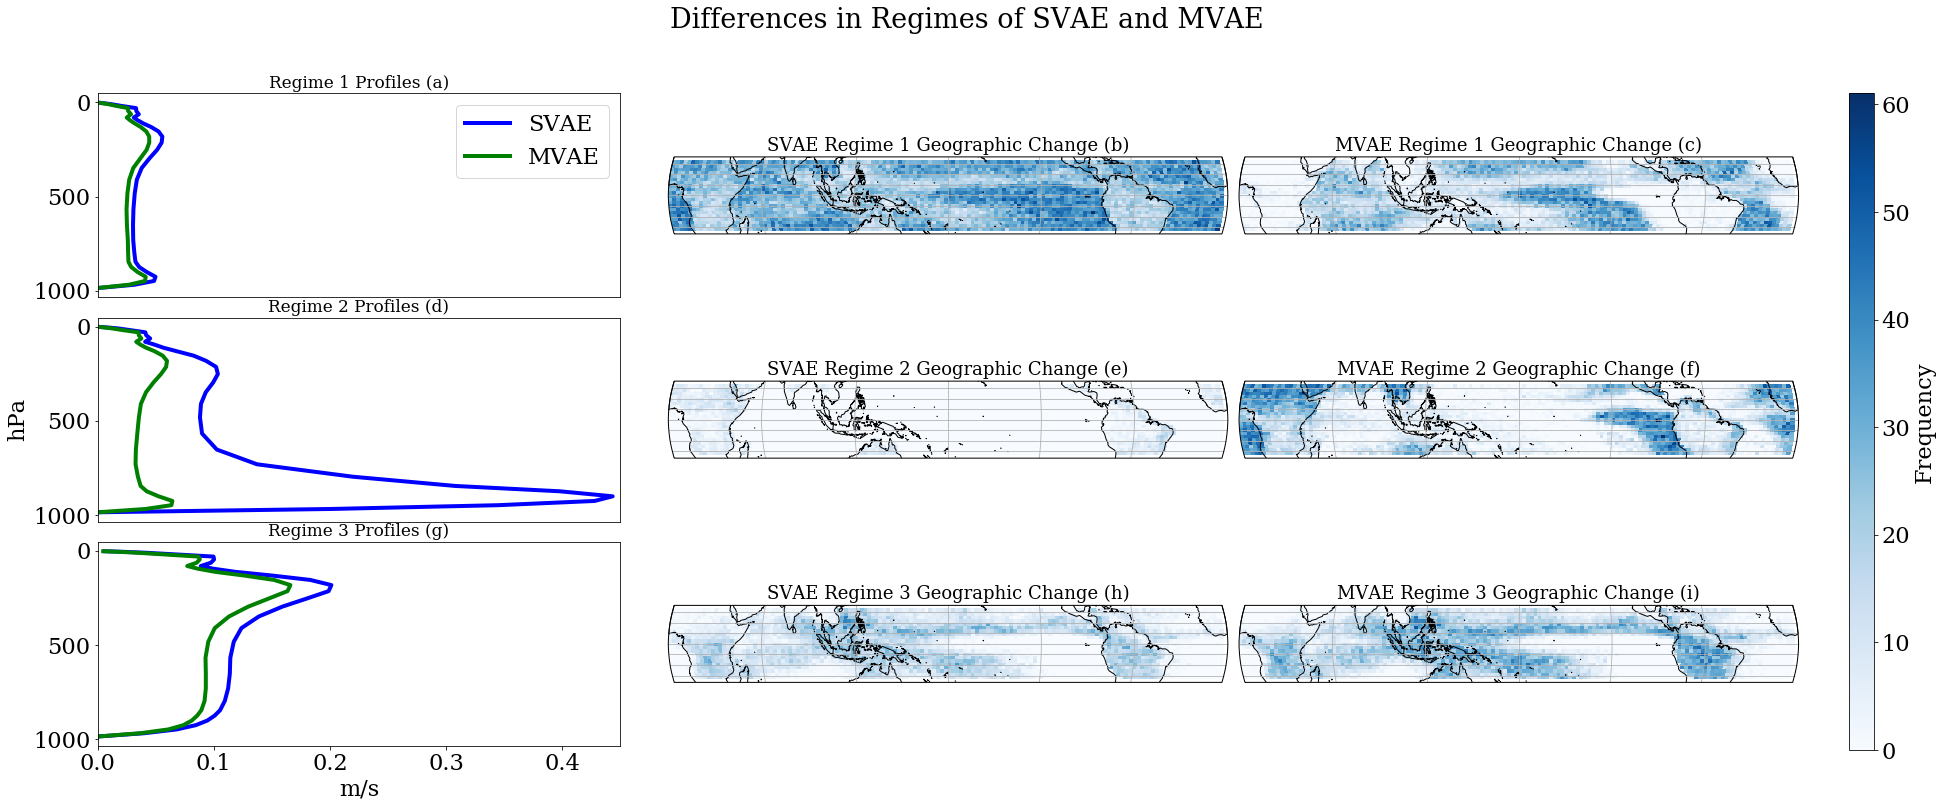

In [35]:
# fig, ax = plt.subplots(6,2,figsize=(25,10),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
fig, ax = plt.subplots(3,3,figsize=(35,12),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
# gs=GridSpec(3,3, width_ratios=[1.9, 2.1])
gs=GridSpec(3,3, width_ratios=[1.9, 2.1, 2.1])

ax1=fig.add_subplot(gs[0,0])
ax1.plot(np.flipud(SingleVAE_ww_mean_profile_1), Pressures_real[:-1]/100.0, c="blue", label = 'SVAE')
# ax1.plot(np.flipud(SingleVAE_ww_25th_profile_1), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
# ax1.plot(np.flipud(SingleVAE_ww_75th_profile_1), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
ax1.plot(np.flipud(MultiVAE_ww_mean_profile_2), Pressures_real[:-1]/100.0, c="green", label = 'MVAE')
ax1.set_xlim(0,0.45)
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_xticks([])
ax1.set_title("Regime 1 Profiles (a)", fontsize = 0.75*fz)
ax1.legend()


ax2=fig.add_subplot(gs[1,0])
ax2.plot(np.flipud(SingleVAE_ww_mean_profile_2), Pressures_real[:-1]/100.0, c="blue")
# ax2.plot(np.flipud(SingleVAE_ww_25th_profile_2), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
# ax2.plot(np.flipud(SingleVAE_ww_75th_profile_2), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
ax2.plot(np.flipud(MultiVAE_ww_mean_profile_1), Pressures_real[:-1]/100.0, c="green")
ax2.set_xlim(0,0.45)
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_ylabel("hPa")
ax2.set_xticks([])
ax2.set_title("Regime 2 Profiles (d)", fontsize = 0.75*fz)

ax3=fig.add_subplot(gs[2,0])
ax3.plot(np.flipud(SingleVAE_ww_mean_profile_3), Pressures_real[:-1]/100.0, c="blue")
# ax3.plot(np.flipud(SingleVAE_ww_25th_profile_3), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
# ax3.plot(np.flipud(SingleVAE_ww_75th_profile_3), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
ax3.plot(np.flipud(MultiVAE_ww_mean_profile_3), Pressures_real[:-1]/100.0, c="green")
ax3.set_xlim(0,0.45)
# ax3.yaxis.set_label_coords(-0.15,-0.0)
ax3.set_ylim(ax3.get_ylim()[::-1])
ax3.set_xlabel("m/s")
ax3.set_title("Regime 3 Profiles (g)", fontsize = 0.75*fz)
# ax3.set_xticks([])

contour_plot = ax[0,1].pcolormesh(new_lons, new_lats, SingleVAE_lat_lon_map_counter_1, cmap="Blues", transform=ccrs.PlateCarree(), vmin=0, vmax = vmax)
# ax[0,1].coastlines(linewidth=0.5,edgecolor='0.25') 
ax[0,1].gridlines()
# ax[0,1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax[0,1].add_feature(cfeature.GSHHSFeature(edgecolor='k'))
ax[0,1].set_title("SVAE Regime 1 Geographic Change (b)", fontsize = 0.8*fz)

contour_plot = ax[1,1].pcolormesh(new_lons, new_lats, SingleVAE_lat_lon_map_counter_2, cmap="Blues", transform=ccrs.PlateCarree(), vmin=0, vmax = vmax)
# ax[1,1].coastlines(linewidth=0.5,edgecolor='0.25')
ax[1,1].gridlines()
# ax[1,1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax[1,1].add_feature(cfeature.GSHHSFeature(edgecolor='k'))
ax[1,1].set_title("SVAE Regime 2 Geographic Change (e)", fontsize = 0.8*fz)

contour_plot = ax[2,1].pcolormesh(new_lons, new_lats, SingleVAE_lat_lon_map_counter_3, cmap="Blues", transform=ccrs.PlateCarree(), vmin=0, vmax = vmax)
# ax[2,1].coastlines(linewidth=0.5,edgecolor='0.25')
ax[2,1].gridlines()
# ax[2,1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax[2,1].add_feature(cfeature.GSHHSFeature(edgecolor='k'))
ax[2,1].set_title("SVAE Regime 3 Geographic Change (h)", fontsize = 0.8*fz)

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.83, 0.51, 0.01, 0.4])
# cbar = fig.colorbar(contour_plot, label='Frequency', cax=cbar_ax)

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.82, 0.12, 0.01, 0.76])
# fig.colorbar(contour_plot, label="Percent", cax=cbar_ax)
# plt.suptitle("Differences in Regimes SingleChannel VAE", y = 0.98, x=0.47)
# plt.subplots_adjust(wspace=0.001)

# fig.delaxes(ax[0,0])
# fig.delaxes(ax[1,0])
# fig.delaxes(ax[2,0])

# plt.savefig("Figures/singlechannelVAEregimes.png")
# #plt.savefig("Figures/Figure_2.pdf")

# fig, ax = plt.subplots(3,2,figsize=(25,10),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
# gs=GridSpec(3,2, width_ratios=[1.9, 2.1])

# ax4=fig.add_subplot(gs[3,0])
# ax4.plot(np.flipud(MultiVAE_ww_mean_profile_1), Pressures_real[:-1]/100.0, c="green")
# # ax4.plot(np.flipud(MultiVAE_ww_25th_profile_1), Pressures_real[:-1]/100.0, c="green", linestyle="dashed")
# # ax4.plot(np.flipud(MultiVAE_ww_75th_profile_1), Pressures_real[:-1]/100.0, c="green", linestyle="dashed")
# ax4.set_xlim(0,0.6)
# ax4.set_ylim(ax4.get_ylim()[::-1])
# ax4.set_xticks([])
# ax4.set_title("MVAE Regime 1 Profile (g)", fontsize = 0.8*fz)
# ax4.legend()

# ax5=fig.add_subplot(gs[4,0])
# ax5.plot(np.flipud(MultiVAE_ww_mean_profile_2), Pressures_real[:-1]/100.0, c="green")
# # ax5.plot(np.flipud(MultiVAE_ww_25th_profile_2), Pressures_real[:-1]/100.0, c="green", linestyle="dashed")
# # ax5.plot(np.flipud(MultiVAE_ww_75th_profile_2), Pressures_real[:-1]/100.0, c="green", linestyle="dashed")
# ax5.set_xlim(0,0.6)
# ax5.set_ylim(ax5.get_ylim()[::-1])
# ax5.set_xticks([])
# ax5.set_title("MVAE Regime 2 Profile (i)", fontsize = 0.8*fz)

# # ax6=fig.add_subplot(gs[5,0])
# ax6.plot(np.flipud(MultiVAE_ww_mean_profile_3), Pressures_real[:-1]/100.0, c="green")
# # ax6.plot(np.flipud(MultiVAE_ww_25th_profile_3), Pressures_real[:-1]/100.0, c="green", linestyle="dashed")
# # ax6.plot(np.flipud(MultiVAE_ww_75th_profile_3), Pressures_real[:-1]/100.0, c="green", linestyle="dashed")
# ax6.set_xlim(0,0.6)
# ax6.set_ylim(ax6.get_ylim()[::-1])
# ax6.set_xlabel("m/s")
# ax6.set_title("MVAE Regime 3 Profile (k)", fontsize = 0.8*fz)

contour_plot = ax[0,2].pcolormesh(new_lons, new_lats, MultiVAE_lat_lon_map_counter_1, cmap="Blues", transform=ccrs.PlateCarree(), vmin=0, vmax = vmax)
# ax[0,1].coastlines(linewidth=0.5,edgecolor='0.25') 
ax[0,2].gridlines()
# ax[0,1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax[0,2].add_feature(cfeature.GSHHSFeature(edgecolor='k'))
ax[0,2].set_title("MVAE Regime 1 Geographic Change (c)", fontsize = 0.8*fz)

contour_plot = ax[1,2].pcolormesh(new_lons, new_lats, MultiVAE_lat_lon_map_counter_2, cmap="Blues", transform=ccrs.PlateCarree(), vmin=0, vmax = vmax)
# ax[1,1].coastlines(linewidth=0.5,edgecolor='0.25')
ax[1,2].gridlines()
# ax[1,1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax[1,2].add_feature(cfeature.GSHHSFeature(edgecolor='k'))
ax[1,2].set_title("MVAE Regime 2 Geographic Change (f)", fontsize = 0.8*fz)

contour_plot = ax[2,2].pcolormesh(new_lons, new_lats, MultiVAE_lat_lon_map_counter_3, cmap="Blues", transform=ccrs.PlateCarree(), vmin=0, vmax = vmax)
# ax[2,1].coastlines(linewidth=0.5,edgecolor='0.25')
ax[2,2].gridlines()
# ax[2,1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax[2,2].add_feature(cfeature.GSHHSFeature(edgecolor='k'))
ax[2,2].set_title("MVAE Regime 3 Geographic Change (i)", fontsize = 0.8*fz)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.01, 0.76])
fig.colorbar(contour_plot, label="Frequency", cax=cbar_ax)
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.83, 0.125, 0.01, 0.36])
# cbar = fig.colorbar(contour_plot, label='Frequency', cax=cbar_ax)

plt.suptitle("Differences in Regimes of SVAE and MVAE", y = 0.98, x=0.47)
plt.subplots_adjust(wspace=.02, hspace = 0.1)




fig.delaxes(ax[0,0])
fig.delaxes(ax[1,0])
fig.delaxes(ax[2,0])

plt.savefig("Figures/Figure_2.png")
plt.savefig("Figures/Figure_2.pdf")

# Convection labels will needed to be changed or swapped

- maybe the colorscale too (vmax/vmin parameters)

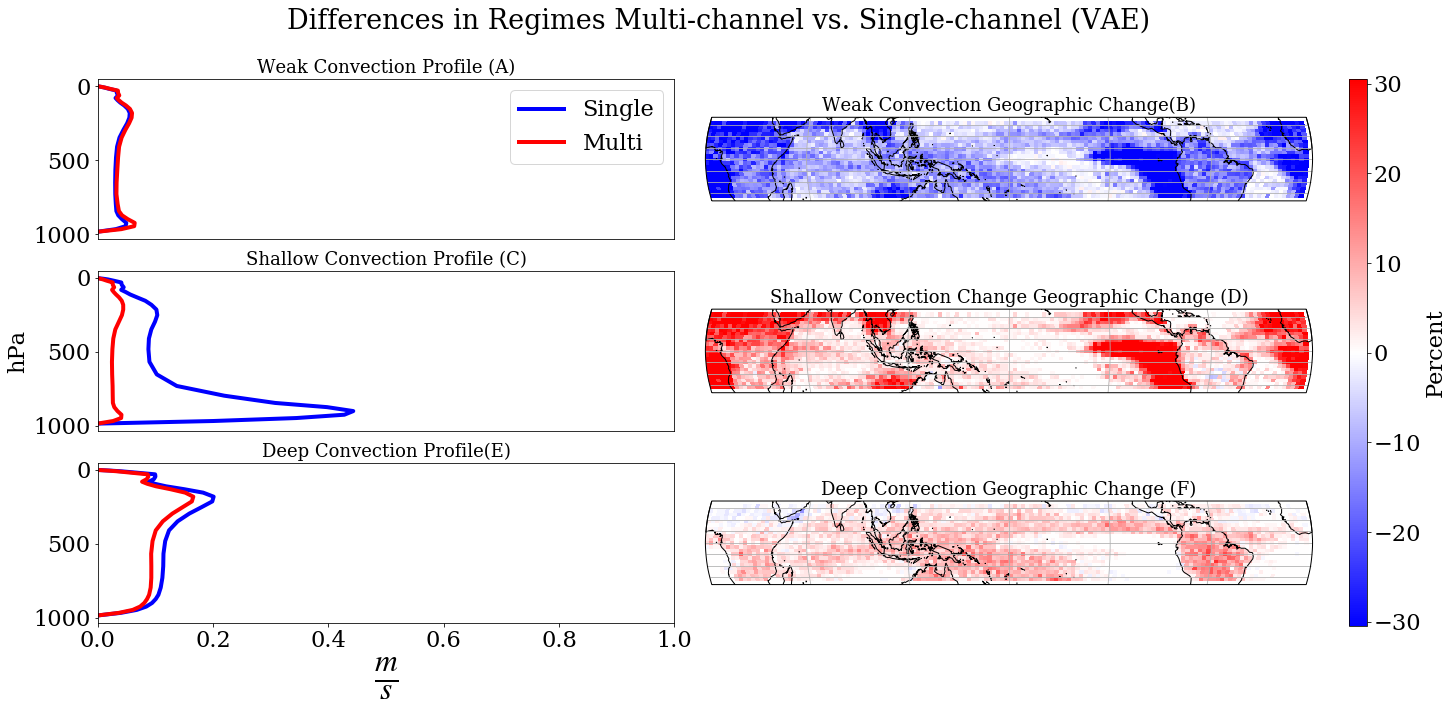

In [24]:
fig, ax = plt.subplots(3,2,figsize=(25,10),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
gs=GridSpec(3,2, width_ratios=[1.9, 2.1])

ax1=fig.add_subplot(gs[0,0])
ax1.plot(np.flipud(SingleVAE_ww_mean_profile_1), Pressures_real[:-1]/100.0, c="blue", label="Single")
cs = ax1.plot(np.flipud(MultiVAE_ww_mean_profile_1), Pressures_real[:-1]/100.0, c="red", label="Multi")
ax1.set_xlim(0,1.0)
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_xticks([])
ax1.set_title("Weak Convection Profile (A)", fontsize = 0.8*fz)
ax1.legend()

ax2=fig.add_subplot(gs[1,0])
ax2.plot(np.flipud(SingleVAE_ww_mean_profile_2), Pressures_real[:-1]/100.0, c="blue")
cs = ax2.plot(np.flipud(MultiVAE_ww_mean_profile_2), Pressures_real[:-1]/100.0, c="red")
ax2.set_xlim(0,1.0)
ax2.set_ylabel("hPa")
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_xticks([])
ax2.set_title("Shallow Convection Profile (C)", fontsize = 0.8*fz)

ax3=fig.add_subplot(gs[2,0])
ax3.plot(np.flipud(SingleVAE_ww_mean_profile_3), Pressures_real[:-1]/100.0, c="blue")
cs = ax3.plot(np.flipud(MultiVAE_ww_mean_profile_3), Pressures_real[:-1]/100.0, c="red")
ax3.set_xlim(0,1.0)
ax3.set_ylim(ax3.get_ylim()[::-1])
ax3.set_xlabel(r"$\frac{m}{s}$", fontsize=fz*2.0)
ax3.set_title("Deep Convection Profile(E)", fontsize = 0.8*fz)

contour_plot = ax[0,1].pcolormesh(new_lons, new_lats, MultiVAE_lat_lon_map_counter_1 - SingleVAE_lat_lon_map_counter_1, cmap="bwr", transform=ccrs.PlateCarree(), vmin=-vmax/2, vmax = vmax/2)
# ax[0,1].coastlines(linewidth=0.5,edgecolor='0.25') 
ax[0,1].gridlines()
# ax[0,1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax[0,1].add_feature(cfeature.GSHHSFeature(edgecolor='k'))
ax[0,1].set_title("Weak Convection Geographic Change(B)", fontsize = 0.8*fz)

contour_plot = ax[1,1].pcolormesh(new_lons, new_lats, MultiVAE_lat_lon_map_counter_2 - SingleVAE_lat_lon_map_counter_2, cmap="bwr", transform=ccrs.PlateCarree(), vmin=-vmax/2, vmax = vmax/2)
# ax[1,1].coastlines(linewidth=0.5,edgecolor='0.25')
ax[1,1].gridlines()
# ax[1,1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax[1,1].add_feature(cfeature.GSHHSFeature(edgecolor='k'))
ax[1,1].set_title("Shallow Convection Change Geographic Change (D)", fontsize = 0.8*fz)

contour_plot = ax[2,1].pcolormesh(new_lons, new_lats, MultiVAE_lat_lon_map_counter_3 - SingleVAE_lat_lon_map_counter_3, cmap="bwr", transform=ccrs.PlateCarree(), vmin=-vmax/2, vmax = vmax/2)
# ax[2,1].coastlines(linewidth=0.5,edgecolor='0.25')
ax[2,1].gridlines()
# ax[2,1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax[2,1].add_feature(cfeature.GSHHSFeature(edgecolor='k'))
ax[2,1].set_title("Deep Convection Geographic Change (F)", fontsize = 0.8*fz)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.01, 0.76])
fig.colorbar(contour_plot, label="Percent", cax=cbar_ax)
plt.suptitle("Differences in Regimes Multi-channel vs. Single-channel (VAE)", y = 0.98, x=0.47)
plt.subplots_adjust(wspace=0.001)

fig.delaxes(ax[0,0])
fig.delaxes(ax[1,0])
fig.delaxes(ax[2,0])

#plt.savefig("Figures/Figure_2.png")
#plt.savefig("Figures/Figure_2.pdf")

## Now do for 4 Groups

### Need to change this path

In [25]:
labels_4_multi = np.load("Compressed_Data/Big_Scaled_Reinitialized_0K_Climate_Labels_3100_Z_4.npy")

In [26]:
Group_4_MultiVAE_ww_test_1 = ww_test[labels_4_multi ==0,:,:]
Group_4_MultiVAE_ww_test_2 = ww_test[labels_4_multi ==1,:,:]
Group_4_MultiVAE_ww_test_3 = ww_test[labels_4_multi ==2,:,:]
Group_4_MultiVAE_ww_test_4 = ww_test[labels_4_multi ==3,:,:]

In [27]:
Group_4_MultiVAE_ww_profiles_1 = np.empty(shape=(len(Group_4_MultiVAE_ww_test_1)*len(Group_4_MultiVAE_ww_test_1[0][0]), len(Group_4_MultiVAE_ww_test_1[0])))
Group_4_MultiVAE_ww_profiles_2 = np.empty(shape=(len(Group_4_MultiVAE_ww_test_2)*len(Group_4_MultiVAE_ww_test_2[0][0]), len(Group_4_MultiVAE_ww_test_2[0])))
Group_4_MultiVAE_ww_profiles_3 = np.empty(shape=(len(Group_4_MultiVAE_ww_test_3)*len(Group_4_MultiVAE_ww_test_3[0][0]), len(Group_4_MultiVAE_ww_test_3[0])))
Group_4_MultiVAE_ww_profiles_4 = np.empty(shape=(len(Group_4_MultiVAE_ww_test_4)*len(Group_4_MultiVAE_ww_test_4[0][0]), len(Group_4_MultiVAE_ww_test_4[0])))

for i in range(len(Group_4_MultiVAE_ww_test_1[0])):
    Group_4_MultiVAE_ww_profiles_1[:,i] = Group_4_MultiVAE_ww_test_1[:,i,:].flatten()
    Group_4_MultiVAE_ww_profiles_2[:,i] = Group_4_MultiVAE_ww_test_2[:,i,:].flatten()
    Group_4_MultiVAE_ww_profiles_3[:,i] = Group_4_MultiVAE_ww_test_3[:,i,:].flatten()
    Group_4_MultiVAE_ww_profiles_4[:,i] = Group_4_MultiVAE_ww_test_4[:,i,:].flatten()

In [28]:
Group_4_MultiVAE_ww_mean_profile_1 = np.median(Group_4_MultiVAE_ww_profiles_1, axis = 0)
Group_4_MultiVAE_ww_25th_profile_1 = np.percentile(Group_4_MultiVAE_ww_profiles_1, 25, axis = 0)
Group_4_MultiVAE_ww_75th_profile_1 = np.percentile(Group_4_MultiVAE_ww_profiles_1, 75, axis = 0)

Group_4_MultiVAE_ww_mean_profile_2 = np.median(Group_4_MultiVAE_ww_profiles_2, axis = 0)
Group_4_MultiVAE_ww_25th_profile_2 = np.percentile(Group_4_MultiVAE_ww_profiles_2, 25, axis = 0)
Group_4_MultiVAE_ww_75th_profile_2 = np.percentile(Group_4_MultiVAE_ww_profiles_2, 75, axis = 0)

Group_4_MultiVAE_ww_mean_profile_3 = np.median(Group_4_MultiVAE_ww_profiles_3, axis = 0)
Group_4_MultiVAE_ww_25th_profile_3 = np.percentile(Group_4_MultiVAE_ww_profiles_3, 25, axis = 0)
Group_4_MultiVAE_ww_75th_profile_3 = np.percentile(Group_4_MultiVAE_ww_profiles_3, 75, axis = 0)

Group_4_MultiVAE_ww_mean_profile_4 = np.median(Group_4_MultiVAE_ww_profiles_4, axis = 0)
Group_4_MultiVAE_ww_25th_profile_4 = np.percentile(Group_4_MultiVAE_ww_profiles_4, 25, axis = 0)
Group_4_MultiVAE_ww_75th_profile_4 = np.percentile(Group_4_MultiVAE_ww_profiles_4, 75, axis = 0)

In [29]:
Group_4_MultiVAE_lat_lon_map_counter_1 = np.zeros(shape=(22,144))
Group_4_MultiVAE_lat_lon_map_counter_2 = np.zeros(shape=(22,144))
Group_4_MultiVAE_lat_lon_map_counter_3 = np.zeros(shape=(22,144))
Group_4_MultiVAE_lat_lon_map_counter_4 = np.zeros(shape=(22,144))

In [30]:
for i in range(len(labels_4_multi)):
    if labels_4_multi[i] == 0:
        Group_4_MultiVAE_lat_lon_map_counter_1[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] = Group_4_MultiVAE_lat_lon_map_counter_1[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] + 1
    if labels_4_multi[i] == 1:
        Group_4_MultiVAE_lat_lon_map_counter_2[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] = Group_4_MultiVAE_lat_lon_map_counter_2[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] + 1
    if labels_4_multi[i] == 2:
        Group_4_MultiVAE_lat_lon_map_counter_3[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] = Group_4_MultiVAE_lat_lon_map_counter_3[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] + 1
    if labels_4_multi[i] == 3:
        Group_4_MultiVAE_lat_lon_map_counter_4[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] = Group_4_MultiVAE_lat_lon_map_counter_4[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] + 1

In [31]:
vmax = max([np.max(Group_4_MultiVAE_lat_lon_map_counter_1),np.max(Group_4_MultiVAE_lat_lon_map_counter_2),np.max(Group_4_MultiVAE_lat_lon_map_counter_3),np.max(Group_4_MultiVAE_lat_lon_map_counter_4)])

No handles with labels found to put in legend.


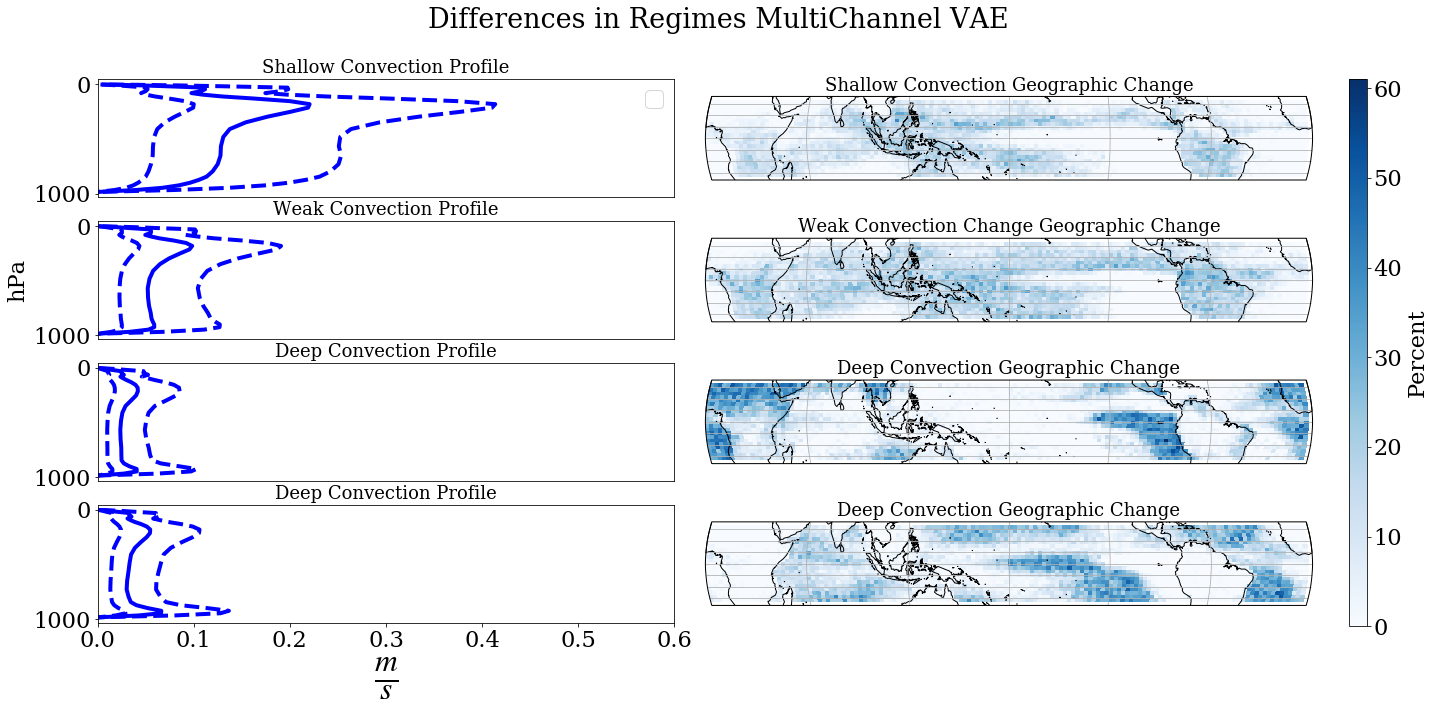

In [32]:
fig, ax = plt.subplots(4,2,figsize=(25,10),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
gs=GridSpec(4,2, width_ratios=[1.9, 2.1])

ax1=fig.add_subplot(gs[0,0])
ax1.plot(np.flipud(Group_4_MultiVAE_ww_mean_profile_1), Pressures_real[:-1]/100.0, c="blue")
ax1.plot(np.flipud(Group_4_MultiVAE_ww_25th_profile_1), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
ax1.plot(np.flipud(Group_4_MultiVAE_ww_75th_profile_1), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
ax1.set_xlim(0,0.6)
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_xticks([])
ax1.set_title("Shallow Convection Profile", fontsize = 0.8*fz)
ax1.legend()

ax2=fig.add_subplot(gs[1,0])
ax2.plot(np.flipud(Group_4_MultiVAE_ww_mean_profile_2), Pressures_real[:-1]/100.0, c="blue")
ax2.plot(np.flipud(Group_4_MultiVAE_ww_25th_profile_2), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
ax2.plot(np.flipud(Group_4_MultiVAE_ww_75th_profile_2), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
ax2.set_xlim(0,0.6)
ax2.set_ylabel("hPa")
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_xticks([])
ax2.set_title("Weak Convection Profile", fontsize = 0.8*fz)

ax3=fig.add_subplot(gs[2,0])
ax3.plot(np.flipud(Group_4_MultiVAE_ww_mean_profile_3), Pressures_real[:-1]/100.0, c="blue")
ax3.plot(np.flipud(Group_4_MultiVAE_ww_25th_profile_3), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
ax3.plot(np.flipud(Group_4_MultiVAE_ww_75th_profile_3), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
ax3.set_xlim(0,0.6)
ax3.set_ylim(ax3.get_ylim()[::-1])
ax3.set_xticks([])
ax3.set_title("Deep Convection Profile", fontsize = 0.8*fz)

ax4=fig.add_subplot(gs[3,0])
ax4.plot(np.flipud(Group_4_MultiVAE_ww_mean_profile_4), Pressures_real[:-1]/100.0, c="blue")
ax4.plot(np.flipud(Group_4_MultiVAE_ww_25th_profile_4), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
ax4.plot(np.flipud(Group_4_MultiVAE_ww_75th_profile_4), Pressures_real[:-1]/100.0, c="blue", linestyle="dashed")
ax4.set_xlim(0,0.6)
ax4.set_ylim(ax4.get_ylim()[::-1])
ax4.set_xlabel(r"$\frac{m}{s}$", fontsize=fz*2.0)
ax4.set_title("Deep Convection Profile", fontsize = 0.8*fz)

contour_plot = ax[0,1].pcolormesh(new_lons, new_lats, Group_4_MultiVAE_lat_lon_map_counter_1, cmap="Blues", transform=ccrs.PlateCarree(), vmin=0, vmax = vmax)
# ax[0,1].coastlines(linewidth=0.5,edgecolor='0.25') 
ax[0,1].gridlines()
# ax[0,1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax[0,1].add_feature(cfeature.GSHHSFeature(edgecolor='k'))
ax[0,1].set_title("Shallow Convection Geographic Change", fontsize = 0.8*fz)

contour_plot = ax[1,1].pcolormesh(new_lons, new_lats, Group_4_MultiVAE_lat_lon_map_counter_2, cmap="Blues", transform=ccrs.PlateCarree(), vmin=0, vmax = vmax)
# ax[1,1].coastlines(linewidth=0.5,edgecolor='0.25')
ax[1,1].gridlines()
# ax[1,1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax[1,1].add_feature(cfeature.GSHHSFeature(edgecolor='k'))
ax[1,1].set_title("Weak Convection Change Geographic Change", fontsize = 0.8*fz)

contour_plot = ax[2,1].pcolormesh(new_lons, new_lats, Group_4_MultiVAE_lat_lon_map_counter_3, cmap="Blues", transform=ccrs.PlateCarree(), vmin=0, vmax = vmax)
# ax[2,1].coastlines(linewidth=0.5,edgecolor='0.25')
ax[2,1].gridlines()
# ax[2,1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax[2,1].add_feature(cfeature.GSHHSFeature(edgecolor='k'))
ax[2,1].set_title("Deep Convection Geographic Change", fontsize = 0.8*fz)

contour_plot = ax[3,1].pcolormesh(new_lons, new_lats, Group_4_MultiVAE_lat_lon_map_counter_4, cmap="Blues", transform=ccrs.PlateCarree(), vmin=0, vmax = vmax)
# ax[3,1].coastlines(linewidth=0.5,edgecolor='0.25')
ax[3,1].gridlines()
# ax[3,1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax[3,1].add_feature(cfeature.GSHHSFeature(edgecolor='k'))
ax[3,1].set_title("Deep Convection Geographic Change", fontsize = 0.8*fz)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.01, 0.76])
fig.colorbar(contour_plot, label="Percent", cax=cbar_ax)
plt.suptitle("Differences in Regimes MultiChannel VAE", y = 0.98, x=0.47)
plt.subplots_adjust(wspace=0.001)

fig.delaxes(ax[0,0])
fig.delaxes(ax[1,0])
fig.delaxes(ax[2,0])
fig.delaxes(ax[3,0])

#plt.savefig("Figures/Figure_2.png")
#plt.savefig("Figures/Figure_2.pdf")